# Rock Physics inversion for water/CO2 saturation from Volcanic attenuation tomography data

In [4]:
from importlib import reload
import volcaniQ as vq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
volcanic_data = vq.CleanReadCSV()
fluids = vq.Fluids()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test Fluid

In [47]:
fluids = vq.Fluids()
co2 = fluids("CarbonDioxide")

0     0.169457
1     0.048452
2     0.044224
3     0.057021
4     0.072445
5     0.088627
6     0.105087
7     0.121649
8     0.138237
9     0.154812
10    0.171355
11    0.187856
12    0.204310
13    0.220714
14    0.237067
15    0.253370
16    0.269624
17    0.285828
18    0.301986
19    0.318098
20    0.334166
21    0.350191
22    0.366175
23    0.382120
24    0.398026
25    0.413895
26    0.429729
27    0.445528
28    0.461294
29    0.477027
30    0.492730
Name: Modulus(GPa), dtype: float64

In [34]:
calibrate = vq.RockPhysicsModelCalibrator()
rpm = calibrate()
test = rpm(omegac = 0.00001,fluid_modulus= 2.2)
test.squirt_flow_model(0)



array([[78.31325674+0.2258746j , 24.48363331+0.30202162j,
        24.48363331+0.30202162j,  0.        +1.1402404j ,
         0.        +1.1402404j ,  0.        +1.1402404j ],
       [24.48363331+0.30202162j, 78.31325674+0.2258746j ,
        24.48363331+0.30202162j,  0.        +1.1402404j ,
         0.        +1.1402404j ,  0.        +1.1402404j ],
       [24.48363331+0.30202162j, 24.48363331+0.30202162j,
        78.31325674+0.2258746j ,  0.        +1.1402404j ,
         0.        +1.1402404j ,  0.        +1.1402404j ],
       [ 0.        +1.1402404j ,  0.        +1.1402404j ,
         0.        +1.1402404j , 27.13071376+1.10709636j,
         0.        +1.1402404j ,  0.        +1.1402404j ],
       [ 0.        +1.1402404j ,  0.        +1.1402404j ,
         0.        +1.1402404j ,  0.        +1.1402404j ,
        27.13071376+1.10709636j,  0.        +1.1402404j ],
       [ 0.        +1.1402404j ,  0.        +1.1402404j ,
         0.        +1.1402404j ,  0.        +1.1402404j ,
         

In [36]:
np.sqrt(rpm.squirt_flow_model(0)[0,0]/2.7)

# rpm().plot()


(5.385626261092311+0.007766715956764999j)

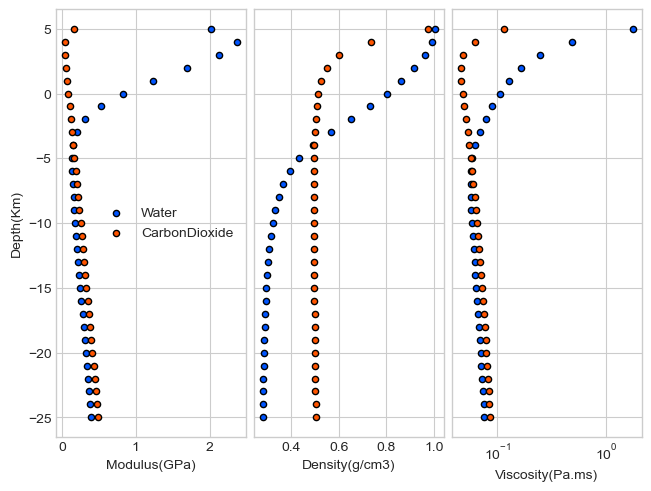

In [44]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 3,constrained_layout = True)

fluid_names = {'Water':  '#0055FF', 'CarbonDioxide':'#FF5500'}
labels = {'Modulus(GPa)':'modulus', 'Density(g/cm3)':'density', 'Viscosity(Pa.ms)': 'viscosity'}

for lab, prop in enumerate(labels):
    for fluid in fluid_names:
        axs[lab].scatter(getattr(fluids(fluid),labels[prop]), -fluids(fluid).depth, c=fluid_names[fluid], s=20, edgecolors='black', label=fluid)
        axs[lab].set_xlabel(prop)

axs[0].legend()
axs[0].set_ylabel('Depth(Km)')

axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axs[2].set_xscale('log')
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


In [40]:
import plotly.express as px
import plotly.graph_objects as go
xmin, xmax = 5, 7
ymin, ymax = -20, -18
fig = px.scatter(volcanic_data.data[volcanic_data.data['z'] ==-5], x='x', y='y',
              color='Qp')
fig.add_shape(type="rect",
    x0=xmin, y0=ymin, x1=xmax, y1=ymax,
    line=dict(color="White"),
    fillcolor="White",
    opacity=0.9,
)
fig.update_yaxes(
      scaleanchor="x",
      scaleratio=1,
)

fig.show()

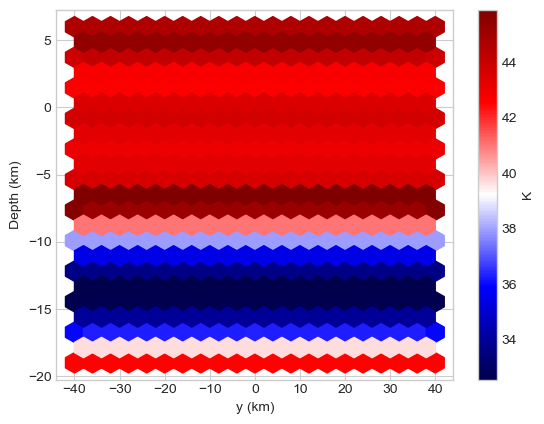

<Figure size 4212x4212 with 0 Axes>

In [281]:
volcanic_data.hexplot(plot="K", direction='x', value=1., grid=20)

<AxesSubplot:xlabel='z'>

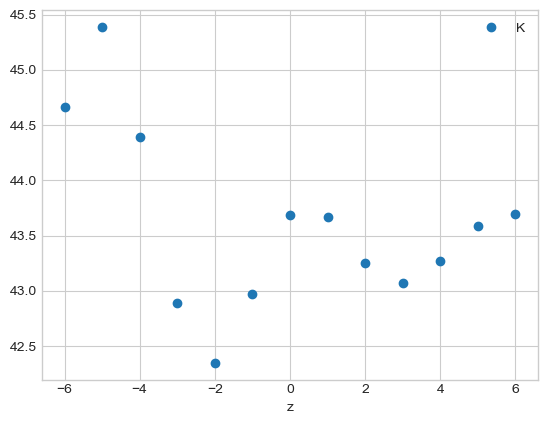

In [290]:
volcanic_data.data\
    [
    volcanic_data.data["z"].between(-6,6) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()\
    .plot(y='K', style='o')

In [3]:
def avg_values(depth: int) -> dict:
    dict = {}
    temp_data = (volcanic_data.data['z'] == depth)
    Qp = volcanic_data.data[temp_data & (volcanic_data.data['Qp'].notna())]["Qp"].min()
    Qs = volcanic_data.data[temp_data & volcanic_data.data['Qs'].notna()]["Qs"].min()
    K = volcanic_data.data[temp_data & volcanic_data.data['K'].notna()]["K"].mean()
    mu = volcanic_data.data[temp_data & volcanic_data.data['μ'].notna()]["μ"].mean()
    rho = volcanic_data.data[temp_data & volcanic_data.data['μ'].notna()]["ρ"].mean()
    dict['Qp'] = Qp
    dict['Qs'] = Qs
    dict['K'] = K
    dict['mu'] = mu
    dict['rho'] = rho
    return dict
avg_values(1)
   

{'Qp': 42.93, 'Qs': 40.93, 'K': 43.67, 'mu': 26.5, 'rho': 2.649999999999999}

In [242]:
volcanic_data.data['K/mu'] = volcanic_data.data['K']/volcanic_data.data['μ']

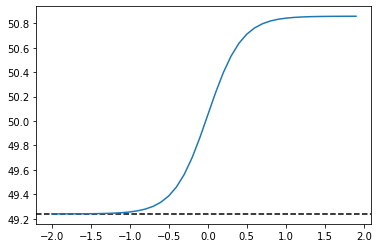

In [68]:
model1 = vq.RockPhysicsModel(dry_modulus=20.,shear_modulus=20, mineral_modulus=38, porosity=0.2, density=2.65)
model1.plot(fluid_modulus=2.5, epsilon=.03, tau=1)

In [66]:
highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]
mod = highQpdata.K
she = highQsdata.μ
mod.mean(), she.mean()

<ipython-input-66-49cd03391929>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
<ipython-input-66-49cd03391929>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]


(43.68873573573574, 26.02604200853298)